In [224]:
from requests import get
from bs4 import BeautifulSoup
from warnings import warn
from time import sleep
from random import randint
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Scraping Part

In [291]:
# Note this takes about 10 min to run if pages_range is set to 6001 .
pages_range = 6001
pages = np.arange(0,pages_range, 50) # pages are going by 50 films per page
headers = {'Accept-Language': 'en-US,en;q=0.8'} # If this is not specified, the default language is Mandarin

#initialize empty lists to store the variables scraped
titles = []
years = []
ratings = []
genres = []
runtimes = []
imdb_ratings = []
imdb_ratings_standardized = []
metascores = []
votes = []
directors = []
response = get("https://www.imdb.com/search/title?genres=sci-fi&"
                  + "start="
                  + str(pages[0])
                  + "&explore=title_type,genres&ref_=adv_prv", headers=headers)
response
page_html = BeautifulSoup(response.text, 'html.parser')
page_html
movie_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')

In [226]:
# "https://www.imdb.com/search/title?genres=sci-fi&start=64&explore=title_type,genres&ref_=adv_prv"

### how to extract the film's genre


In [227]:
movie_containers[0].p.find('span', class_= "genre").text.replace("\n", "").strip()

'Action, Adventure, Comedy'

### how to extarct the movie name


In [228]:
movie_containers[0].h3.find("a").text

'Gen V'

### the imdb rating


In [229]:
movie_containers[0].strong.text

'8.0'

### the director's name


In [230]:
# here we use the find method afforded by the bs4 method not find of the string class
movie_containers[0].find("p", class_='').find("a").text

'Jaz Sinclair'

In [231]:
star_elemnts = movie_containers[0].find("p", class_ = "").find_all("a")
names = [s.text for s in star_elemnts]
#verifying data coherance
star_names = names[1:]
star_names

['Chance Perdomo', 'Lizze Broadway', 'Maddie Phillips']

### The main loop:
it loops over the web pages and collects data for every film in that page, the container here refer to the part which
contains all infos about a film

In [232]:
for page in pages:
  
   #get request for sci-fi
   response = get("https://www.imdb.com/search/title?genres=sci-fi&"
                  + "start="
                  + str(page)
                  + "&explore=title_type,genres&ref_=adv_prv", headers=headers)
  
   sleep(randint(8,15))
   
   #throw warning for status codes that are not 200
   if response.status_code != 200:
       warn('Request: {}; Status code: {}'.format(requests, response.status_code))

   #parse the content of current iteration of request
   page_html = BeautifulSoup(response.text, 'html.parser')
      
   movie_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')
  
   #extract the 50 movies for that page
   for container in movie_containers:

       #conditional for all with metascore, this doesn t consider movies without metascore
       if container.find('div', class_ = 'ratings-metascore') is not None:

           #title
           title = container.h3.find("a").text
           titles.append(title)

           if container.h3.find('span', class_= 'lister-item-year text-muted unbold') is not None:
            
             #year released
             year = container.h3.find('span', class_= 'lister-item-year text-muted unbold').text # remove the parentheses around the year and make it an integer
             years.append(year)

           else:
             years.append(None) # each of the additional if clauses are to handle type None data, replacing it with an empty string so the arrays are of the same length at the end of the scraping

           if container.p.find('span', class_ = 'genre') is not None:
            
             #genre
             genre = container.p.find('span', class_ = 'genre').text.replace("\n", "").rstrip().split(',') # remove the whitespace character, strip, and split to create an array of genres
             genres.append(genre)
          
           else:
             genres.append("")

           if container.p.find('span', class_ = 'runtime') is not None:

             #runtime
             time = int(container.p.find('span', class_ = 'runtime').text.replace(" min", "")) # remove the minute word from the runtime and make it an integer
             runtimes.append(time)

           else:
             runtimes.append(None)

           if float(container.strong.text) is not None:

             #IMDB ratings
             imdb = float(container.strong.text) # non-standardized variable
             imdb_ratings.append(imdb)

           else:
             imdb_ratings.append(None)

           if container.find('span', class_ = 'metascore').text is not None:

             #Metascore
             m_score = int(container.find('span', class_ = 'metascore').text) # make it an integer
             metascores.append(m_score)

           else:
             metascores.append(None)
               # 
           if container.find("p", class_='').find("a").text is not None:

             #Director
             d = container.find("p", class_='').find("a").text
             directors.append(d)
           else:
             directors.append("Not found")
           if container.find('span', attrs = {'name':'nv'})['data-value'] is not None:

             #Number of votes
             vote = int(container.find('span', attrs = {'name':'nv'})['data-value'])
             votes.append(vote)

           else:
               votes.append(None)

### Organizing collected data


In [233]:
titles_data = pd.DataFrame(titles, columns= ["Title"])
directors_data = pd.DataFrame(directors, columns=["Director"])
runtimes_data = pd.DataFrame(runtimes, columns=["Runtime"])
imdb_ratings_data = pd.DataFrame(imdb_ratings, columns=["Imdb_Rating"])

In [234]:
meta_data = pd.concat([titles_data, directors_data, runtimes_data, imdb_ratings_data], axis = 1)
meta_data.head(20)

,Title,Director,Runtime,Imdb_Rating
0,The Creator,Gareth Edwards,133,7.1
1,No One Will Save You,Brian Duffield,93,6.3
2,Elemental,Peter Sohn,101,7.0
3,Meg 2: The Trench,Ben Wheatley,116,5.1
4,Poor Things,Yorgos Lanthimos,141,8.5
5,Blue Beetle,Angel Manuel Soto,127,6.1
6,PAW Patrol: The Mighty Movie,Cal Brunker,88,6.0
7,Spider-Man: Across the Spider-Verse,Joaquim Dos Santos,140,8.7
8,Teenage Mutant Ninja Turtles: Mutant Mayhem,Jeff Rowe,99,7.3
9,Dune,Denis Villeneuve,155,8.0


# The data analysis part

In [235]:
#creating a copy of data
data = meta_data.copy()
data.head(10)

,Title,Director,Runtime,Imdb_Rating
0,The Creator,Gareth Edwards,133,7.1
1,No One Will Save You,Brian Duffield,93,6.3
2,Elemental,Peter Sohn,101,7.0
3,Meg 2: The Trench,Ben Wheatley,116,5.1
4,Poor Things,Yorgos Lanthimos,141,8.5
5,Blue Beetle,Angel Manuel Soto,127,6.1
6,PAW Patrol: The Mighty Movie,Cal Brunker,88,6.0
7,Spider-Man: Across the Spider-Verse,Joaquim Dos Santos,140,8.7
8,Teenage Mutant Ninja Turtles: Mutant Mayhem,Jeff Rowe,99,7.3
9,Dune,Denis Villeneuve,155,8.0


In [257]:
#seeking optimizing ideas
data.info()
data["Director"].nunique()
data["Imdb_Rating"].nunique()
data.duplicated(subset=["Title", "Director"]).sum()
data[data["Title"] == "Arrow"]

<class 'pandas.core.frame.DataFrame'>
Index: 1347 entries, 0 to 1347
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Title        1347 non-null   object  
 1   Director     1347 non-null   category
 2   Runtime      1347 non-null   int64   
 3   Imdb_Rating  1347 non-null   float64 
dtypes: category(1), float64(1), int64(1), object(1)
memory usage: 84.5+ KB


,Title,Director,Runtime,Imdb_Rating


In [258]:
#optimizing data loading time
data.drop_duplicates(inplace = True)
data.info()
data.shape


<class 'pandas.core.frame.DataFrame'>
Index: 1347 entries, 0 to 1347
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Title        1347 non-null   object  
 1   Director     1347 non-null   category
 2   Runtime      1347 non-null   int64   
 3   Imdb_Rating  1347 non-null   float64 
dtypes: category(1), float64(1), int64(1), object(1)
memory usage: 84.5+ KB


(1347, 4)

~84% of loading time gained with a 482 rows dataFrame.

#### List of top rated film(s) 

In [259]:
max_rating = data["Imdb_Rating"].max()
top_rated_films = data[data['Imdb_Rating'] == max_rating ]
top_rated_films

,Title,Director,Runtime,Imdb_Rating
21,Inception,Christopher Nolan,148,8.8


#### Top 10 Longest Films

In [260]:
top_long_films = data.sort_values(by = ["Runtime"], ascending=False).head(10)
top_long_films

,Title,Director,Runtime,Imdb_Rating
163,Zack Snyder's Justice League,Zack Snyder,242,7.9
1164,World on a Wire,Klaus Löwitsch,212,7.7
23,Avatar: The Way of Water,James Cameron,192,7.6
41,Avengers: Endgame,Anthony Russo,181,8.4
1120,Hard to Be a God,Aleksey German,177,6.6
597,The Postman,Kevin Costner,177,6.1
269,Waterworld,Kevin Reynolds,177,6.3
642,The Wandering Earth II,Frant Gwo,173,7.0
286,Cloud Atlas,Tom Tykwer,172,7.4
13,Interstellar,Christopher Nolan,169,8.7


#### the director(s) with the greatest number of films

In [261]:
directors_groups =  data.groupby('Director')['Title']
productive_directors = directors_groups.count().reset_index().rename(columns={"Title" : "Number Of Films"}).sort_values(by=["Number Of Films"])
productive_directors = productive_directors[productive_directors["Number Of Films"] == productive_directors["Number Of Films"].max()]
productive_directors.

,Director,Number Of Films
207,David Cronenberg,10
441,John Carpenter,10


#### VisualAverage runtimes for films categirised with runtime

In [262]:
short_films = data[data["Runtime"].between(0,100)]
medium_films = data[data["Runtime"].between(101,160)]
long_films = data[data["Runtime"].between(161,data["Runtime"].max())]


#### Films Ratings in function of Runtime

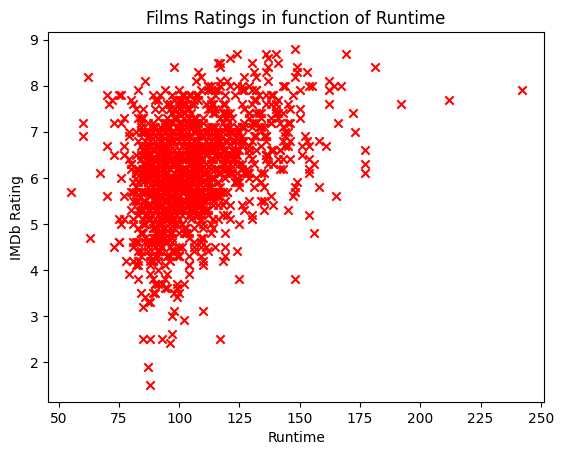

In [263]:
imdb_ratings = data.set_index("Runtime")["Imdb_Rating"]
plt.scatter(imdb_ratings.index, imdb_ratings, marker='x', color = "red")
plt.xlabel("Runtime")
plt.ylabel("IMDb Rating")
plt.title("Films Ratings in function of Runtime")
plt.show()

#### Distribution of IMDb Ratings

In [264]:
imdb_rating_data = data['Imdb_Rating'].value_counts().reset_index().set_index("Imdb_Rating").rename(columns={"count": "Number Of Films"} )
imdb_rating_data.head(10)

,Number Of Films
Imdb_Rating,
6.1,62
5.7,58
6.4,58
6.3,56
6.2,56
6.6,51
6.7,51
6.0,49
5.9,48


<Axes: xlabel='Imdb_Rating'>

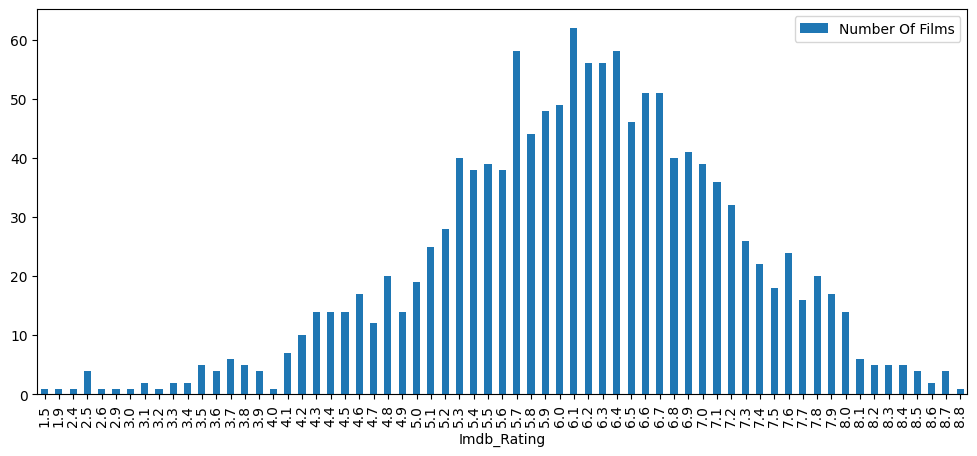

In [274]:
imdb_rating_data["Number Of Films"] = imdb_rating_data["Number Of Films"].astype(int)
imdb_rating_data.sort_values(by = ["Imdb_Rating"]).plot(kind = "bar", figsize = (12,5))

On remarque que cette fonction tend vers une loi normale de moyenne $\mu ~= 6.2$ et d'écart type $\sigma^{2} ~= 0.9$.

In [275]:
data["Runtime"].values

array([133,  93, 101, ...,  81,  92, 111])

#### Visualizing a heatmap of number of films in function of imdb_rating and runtime

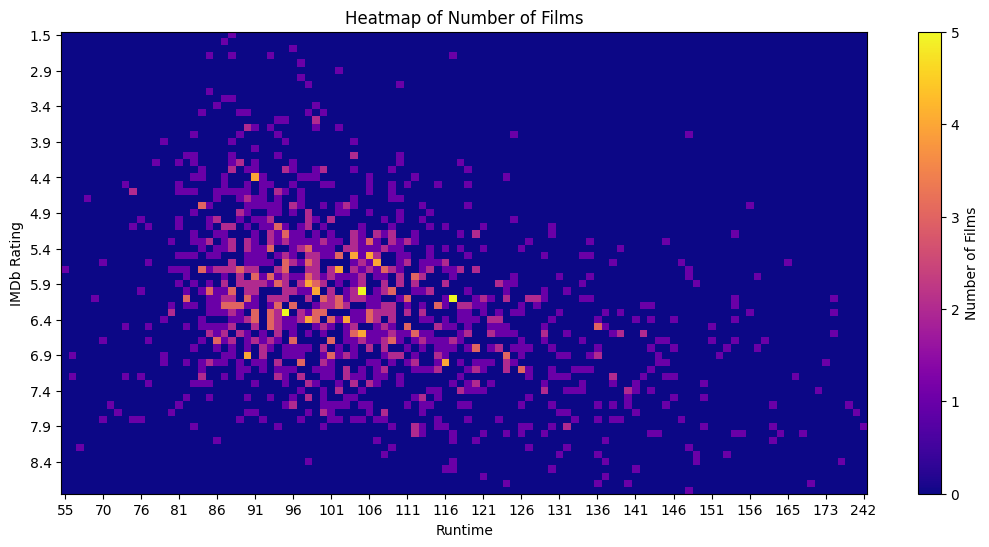

In [293]:
# Create a pivot table with 'Imdb_Rating' as rows, 'Runtime' as columns, and 'Title' as values
heatmap_data = data.pivot_table(values='Title', index='Imdb_Rating', columns='Runtime', aggfunc='count', fill_value=0)

# Create a heatmap
plt.figure(figsize=(13, 6))
plt.imshow(heatmap_data, cmap='plasma', aspect='auto')
plt.colorbar(label='Number of Films')
plt.xlabel('Runtime')
plt.ylabel('IMDb Rating')
plt.title('Heatmap of Number of Films')

# Set x and y ticks to match the index and columns of the heatmap
# Set x and y ticks to increase by 5 for better figure
plt.xticks(range(0, len(heatmap_data.columns), 5), heatmap_data.columns[::5])
plt.yticks(range(0, len(heatmap_data.index), 5), heatmap_data.index[::5])

plt.show()